# Курс "Алгортимы анализа данных"

## Практическое задание урока 6. Градиентный бустинг (AdaBoost)

Реализовать адаптивный бустинг, использующий Логистическую Регрессию и меру ошибок LogLoss. 
Подробнее - в файле "Адаптивный бустинг.ipynb"

Реализовать адаптивный бустинг использующий Логистическую Регрессию и меру ошибок LogLoss. Сравнить с точностью адаптивного бустинга на деревьях решений. Для сбора предсказаний можно использовать ту же функцию predict что и для бустинга на деревьях
Примечания: в LogLoss необходимо передавать не предсказания полученные с помощью clf.predict(...), а вероятность, полученную с помощью clf.predict_proba(...)[:, 1]

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

from sklearn import model_selection
import numpy as np

In [11]:
# Разделим выборку на обучающую и тестовую
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [12]:
# Осуществим предсказание
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

### Адаптивный бустинг на деревьях решеший

In [13]:
# Реализуем функцию подсчета ошибки
def get_error(pred, y):
    return np.sum((pred != y).astype(int)) / len(y)

In [14]:
# Реализуем алгоритм AdaBoost
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, w)

        predictions = clf.predict(X)
        e = get_error(predictions, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

### Адаптивный бустинг, использующий Логистическую Регрессию

In [15]:
# Реализуем функцию подсчета LogLoss
def log_loss(pred, y): 
    return -np.sum(y*np.log(pred)+(1-y)*np.log(1-pred))/len(y)

In [22]:
# Реализуем алгоритм AdaBoost на логистической регрессии
def adaboost_lr(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса деревьев
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        lr = LogisticRegression(solver="liblinear", random_state=27)
        lr.fit(X, y, w)

        predictions = lr.predict(X)
        
        prediction_proba = lr.predict_proba(X)[:,1]
        for i in range(len(prediction_proba)):
            if prediction_proba[i] == 0:
                prediction_proba[i] += 1e-14        
                
        e = log_loss(prediction_proba, y)
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if e >= 1 - 1/n_classes: 
            break

        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - e) / e)

        # Найдем индексы правильно классифицированных элементов
        match = predictions == y

        # Увеличим веса для неправильно классифицированных элементов
        w[~match] *= np.exp(alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, lr))
    
    return models

### Сравнение с точностью адаптивного бустинга на деревьях решений

In [23]:
# Обучим алгоритм из 50 деревьев
N = 50

models = adaboost(X_train, y_train, N)
models_lr = adaboost_lr(X_train, y_train, N)

In [26]:
print(f'Точность алгоритма на деревьях решений на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')
print(f'Точность алгоритма на Логистической Регрессии на обучающей выборке: {(1 - get_error(predict(X_train, models_lr), y_train)) * 100:.3f}')

Точность алгоритма на деревьях решений на обучающей выборке: 99.061
Точность алгоритма на Логистической Регрессии на обучающей выборке: 93.427


In [27]:
print(f'Точность алгоритма на деревьях решений на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')
print(f'Точность алгоритма на Логистической Регресии на тестовой выборке: {(1 - get_error(predict(X_test, models_lr), y_test)) * 100:.3f}')

Точность алгоритма на деревьях решений на тестовой выборке: 96.503
Точность алгоритма на Логистической Регресии на тестовой выборке: 95.105


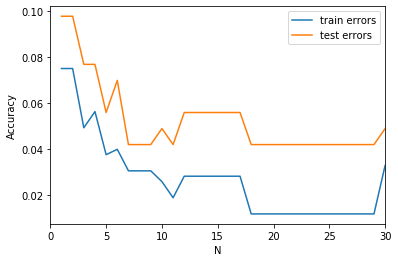

In [28]:
# Для алгоритма на деревьях решений
# Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

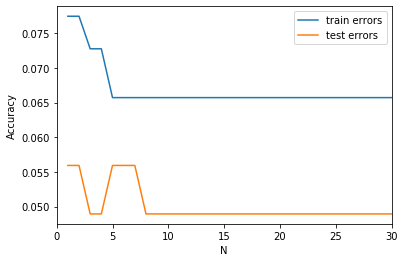

In [29]:
# Для алгоритма на Логистической Регрессии
# Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.
train_errors = []
test_errors = []

for n in range(1, 31):
    mods = adaboost_lr(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, mods), y_train))
    test_errors.append(get_error(predict(X_test, mods), y_test))

x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

В случае исследуемой выборки точность алгоритма на деревьях решений выше, чем точность алгортима на Логистической Регрессии